In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math, warnings
import bubbletea

warnings.filterwarnings('ignore')

2022-04-24 02:54:07.757 
  command:

    streamlit run /Users/shelshoker/.pyenv/versions/3.9.2/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]


In [2]:
HACK_TX_HASHES = [
    '0x7eb2436eedd39c8865fcc1e51ae4a245e89765f4c64a13200c623f676b3912f9', # Alpha Homora V2 Exploiter : Feb-2021
    '0x0fe2542079644e107cbf13690eb9c2c65963ccb79089ff96bfaf8dced2331c92', # Cream v1 Flashloan Exploiter : Oct-2021
    '0xcd314668aaa9bbfebaf1a0bd2b6553d01dd58899c508d4729fa7311dc5d33ad7' # Beanstalk Flashloan Exploiter : Apr-2022
]

# 1. Load Data Using Graph Network

In [3]:
# query MyQuery {
#   flashLoans(where: {timestamp_gt: 1630454400}, orderBy: timestamp) {
#     id
#     target
#     timestamp
#     initiator {
#       id
#       lifetimeRewards
#       unclaimedRewards
#       borrowedReservesCount
#       borrowHistory(first: 10, orderBy: timestamp) {
#         amount
#         timestamp
#       }
#       swapHistory(first: 10, orderBy: timestamp) {
#         timestamp
#         variableBorrowRate
#       }
#       depositHistory(orderBy: timestamp, first: 10) {
#         timestamp
#         amount
#       }
#       incentivesLastUpdated
#       liquidationCallHistory(orderBy: timestamp, first: 10) {
#         timestamp
#         liquidator
#         collateralAmount
#       }
#       redeemUnderlyingHistory(first: 10, orderBy: timestamp) {
#         amount
#         timestamp
#       }
#       originationFeeLiquidationHistory(orderBy: timestamp, first: 10) {
#         timestamp
#       }
#       rebalanceStableBorrowRateHistory(first: 10, orderBy: timestamp) {
#         timestamp
#         borrowRateTo
#         borrowRateFrom
#       }
#     }
#     amount
#     totalFee
#     pool {
#       lendingPool
#       lastUpdateTimestamp
#     }
#     reserve {
#       totalDeposits
#       symbol
#       baseLTVasCollateral
#       lifetimeBorrows
#       lifetimeCurrentVariableDebt
#       lifetimeDepositorsInterestEarned
#       lifetimeFlashLoanPremium
#       lifetimeFlashLoans
#       lifetimeLiquidated
#       lifetimeLiquidity
#       lifetimePrincipalStableDebt
#       lifetimeRepayments
#       lifetimeReserveFactorAccrued
#       lifetimeScaledVariableDebt
#       lifetimeWithdrawals
#       name
#       totalLiquidity
#       totalLiquidityAsCollateral
#       totalPrincipalStableDebt
#       totalScaledVariableDebt
#       underlyingAsset
#     }
#   }
# }

In [4]:
%%time
# # # # # # # # # # # # # # # # #
# Load data from Aave subgraph  #
# # # # # # # # # # # # # # # # #

def graphQL(timestamp_gt):
    url = "https://api.thegraph.com/subgraphs/name/aave/protocol-v2"
    query = "{flashLoans(where: {timestamp_gt:"+str(timestamp_gt)+"}, orderBy: timestamp) {id,target,timestamp,initiator {id,lifetimeRewards,unclaimedRewards,borrowedReservesCount,borrowHistory(first: 10, orderBy: timestamp) {amount,timestamp}, swapHistory(first: 10, orderBy: timestamp) {timestamp,variableBorrowRate}, depositHistory(orderBy: timestamp, first: 10) {timestamp,amount},incentivesLastUpdated,liquidationCallHistory(orderBy: timestamp, first: 10) {timestamp,liquidator,collateralAmount},redeemUnderlyingHistory(first: 10, orderBy: timestamp) {amount,timestamp}, originationFeeLiquidationHistory(orderBy: timestamp, first: 10) {timestamp},rebalanceStableBorrowRateHistory(first: 10, orderBy: timestamp) {timestamp,borrowRateTo,borrowRateFrom}},amount,totalFee,pool {lendingPool,lastUpdateTimestamp},reserve {totalDeposits,symbol,baseLTVasCollateral,lifetimeBorrows,lifetimeCurrentVariableDebt,lifetimeDepositorsInterestEarned,lifetimeFlashLoanPremium,lifetimeFlashLoans,lifetimeLiquidated,lifetimeLiquidity,lifetimePrincipalStableDebt,lifetimeRepayments,lifetimeReserveFactorAccrued,lifetimeScaledVariableDebt,lifetimeWithdrawals,name,totalLiquidity,totalLiquidityAsCollateral,totalPrincipalStableDebt,totalScaledVariableDebt,underlyingAsset}}}" 
    df = bubbletea.beta_load_subgraph(url, query)
    df = df['flashLoans']
    df['amount'] = df["amount"] / math.pow(10, 18)
    return df,int(df.iloc[-1]['timestamp'].timestamp())

df_list,ts = [],1612134000 # 2021-2-1
while True:
    df,tsNext = graphQL(ts)
    df_list.append(df)
    ts = tsNext
    if ts > 1650405600: # 2022-4-20
        break
df = pd.concat(df_list).reset_index(drop=True)

CPU times: user 1min 21s, sys: 1.01 s, total: 1min 22s
Wall time: 5min 9s


In [6]:
def pegged(name):
    if name in ['USD Coin','Dai Stablecoin','Tether USD','Maker','TrueUSD','Synth sUSD','Binance USD']:
        return 'USD'
    elif name in['Wrapped Ether']:
        return 'ETH'
    else:
        return 'Else'
    
df['tx_hash'] = df.id.apply(lambda x: x.split(':')[2])
df['flash_loan_hack'] = df.tx_hash.apply(lambda x: x in HACK_TX_HASHES).astype(int)
df['pegged'] = df['reserve.name'].apply(lambda x: pegged(x))
HACK_TX_PEG = list(df[df.flash_loan_hack==1]['pegged'])
df.head()

,id,target,timestamp,amount,totalFee,initiator.id,initiator.lifetimeRewards,initiator.unclaimedRewards,initiator.borrowedReservesCount,initiator.borrowHistory,...,reserve.lifetimeWithdrawals,reserve.name,reserve.totalLiquidity,reserve.totalLiquidityAsCollateral,reserve.totalPrincipalStableDebt,reserve.totalScaledVariableDebt,reserve.underlyingAsset,pegged,tx_hash,flash_loan_hack
0,11766662:100:0x9c6a677329f47e11d1f8ddf1fa19ea1...,0xbcc4371cc40592794bf5b727c17cf7de37ac180a,2021-01-31 23:00:22,8.398855e-02,7.558970e+13,0xd0d628acf9e985c94a4542cae88e0af7b2378c81,9.976769e+19,0.000000e+00,1,"[{'amount': '83988553879439830', 'timestamp': ...",...,5.474965e+26,TrueUSD,9.540451e+25,8.371783e+25,9.243481e+23,5.256611e+25,0x0000000000085d4780b73119b644ae5ecd22b376,USD,0x9c6a677329f47e11d1f8ddf1fa19ea1f1f5163ec5845...,0
1,11766662:100:0x9c6a677329f47e11d1f8ddf1fa19ea1...,0xbcc4371cc40592794bf5b727c17cf7de37ac180a,2021-01-31 23:00:22,3.544559e-07,3.190103e+08,0xd0d628acf9e985c94a4542cae88e0af7b2378c81,9.976769e+19,0.000000e+00,1,"[{'amount': '83988553879439830', 'timestamp': ...",...,3.045499e+16,USD Coin,2.963138e+15,6.112801e+15,1.261085e+13,2.182035e+15,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD,0x9c6a677329f47e11d1f8ddf1fa19ea1f1f5163ec5845...,0
2,11766780:73:0x671a574788bf158cfede7ee3a85c242f...,0xbcc4371cc40592794bf5b727c17cf7de37ac180a,2021-01-31 23:27:22,7.373415e-09,6.636073e+06,0xf0a2da04f21d743dc73fab07d1796f4362ecff68,2.957948e+17,2.957948e+17,0,"[{'amount': '7373414674', 'timestamp': 1612135...",...,3.045499e+16,USD Coin,2.963138e+15,6.112801e+15,1.261085e+13,2.182035e+15,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD,0x671a574788bf158cfede7ee3a85c242f46db5c4651fc...,0
3,11766847:96:0x2aec3a2d477ac7e1be8acdb7001c1175...,0x498c5431eb517101582988fbb36431ddaac8f4b1,2021-01-31 23:40:38,2.758174e+01,2.482357e+16,0x88202a3d66ddfb2c6fc6ccf6473d8eaf1cd0d2b2,0.000000e+00,0.000000e+00,-1,"[{'amount': '4149592357481478000', 'timestamp'...",...,3.839745e+25,Wrapped Ether,1.419812e+24,4.019103e+24,1.845592e+20,4.705730e+23,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,ETH,0x2aec3a2d477ac7e1be8acdb7001c1175a5b8c1626e0d...,0
4,11767130:118:0xb9813c444b4cc59fd27a6d2e6cb0dd1...,0xbcc4371cc40592794bf5b727c17cf7de37ac180a,2021-02-01 00:40:55,3.025418e-09,2.722876e+06,0x87e6888935180a9b27a9b48b75c9b779bfec1f76,5.359569e+18,5.359569e+18,0,"[{'amount': '3025417948', 'timestamp': 1612140...",...,2.474242e+13,Wrapped BTC,4.572581e+12,4.475641e+12,8.507095e+07,1.536692e+11,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,Else,0xb9813c444b4cc59fd27a6d2e6cb0dd126eee6a67138a...,0


# 2. Analysis

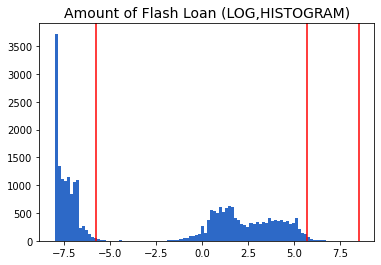

In [7]:
c = 'amount'
plt.title('Amount of Flash Loan (LOG,HISTOGRAM)',size=14)
plt.hist(np.log10(df[c]+1e-8), bins=100, color='#2D69C7')
for i in range(len(HACK_TX_HASHES)):
    plt.axvline(np.log10(df[df.flash_loan_hack==1].reset_index(drop=True)[c].iloc[i]),color='red')
plt.show()


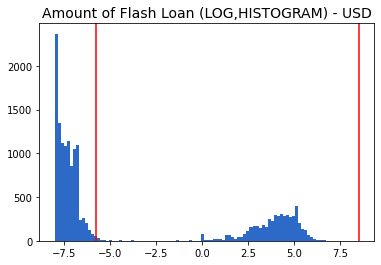

In [8]:
peg = 'USD'
c = 'amount'
plt.title('Amount of Flash Loan (LOG,HISTOGRAM) - USD',size=14)
plt.hist(np.log10(df[df.pegged==peg][c]+1e-8), bins=100, color='#2D69C7')
for i in range(len(HACK_TX_HASHES)):
    if HACK_TX_PEG[i] == peg:
        plt.axvline(np.log10(df[df.flash_loan_hack==1].reset_index(drop=True)[c].iloc[i]),color='red')
plt.show()


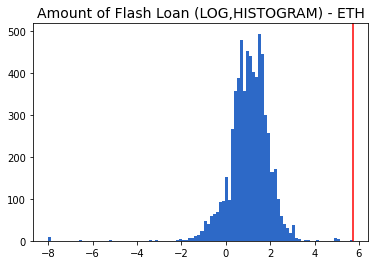

In [9]:
peg = 'ETH'
c = 'amount'
plt.title('Amount of Flash Loan (LOG,HISTOGRAM) - ETH',size=14)
plt.hist(np.log10(df[df.pegged==peg][c]+1e-8), bins=100, color='#2D69C7')
for i in range(len(HACK_TX_HASHES)):
    if HACK_TX_PEG[i] == peg:
        plt.axvline(np.log10(df[df.flash_loan_hack==1].reset_index(drop=True)[c].iloc[i]),color='red')
plt.show()


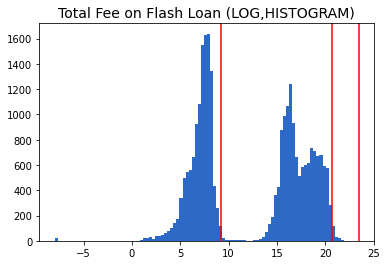

In [10]:
c = 'totalFee'
plt.title('Total Fee on Flash Loan (LOG,HISTOGRAM)',size=14)
plt.hist(np.log10(df[c]+1e-8), bins=100, color='#2D69C7')
for i in range(len(HACK_TX_HASHES)):
    plt.axvline(np.log10(df[df.flash_loan_hack==1].reset_index(drop=True)[c].iloc[i]),color='red')
plt.show()

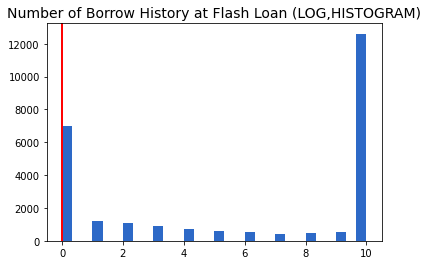

In [11]:
c = 'initiator.borrowHistory'
plt.title('Number of Borrow History at Flash Loan (LOG,HISTOGRAM)',size=14)
plt.hist(df[c].apply(lambda x: len(x)), bins=30, color='#2D69C7')
for i in range(len(HACK_TX_HASHES)):
    plt.axvline(df[df.flash_loan_hack==1][c].apply(lambda x: len(x)).reset_index(drop=True).iloc[i],color='red')
plt.show()

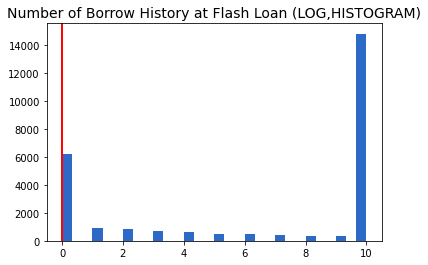

In [12]:
c = 'initiator.depositHistory'
plt.title('Number of Borrow History at Flash Loan (LOG,HISTOGRAM)',size=14)
plt.hist(df[c].apply(lambda x: len(x)), bins=30, color='#2D69C7')
for i in range(len(HACK_TX_HASHES)):
    plt.axvline(df[df.flash_loan_hack==1][c].apply(lambda x: len(x)).reset_index(drop=True).iloc[i],color='red')
plt.show()

# 3. Implications & Further Study

### Implications
- For the sake of developing Web3.0 Ecosystem itself, we propose lending DeFi protocols such as AAVE to eliminate flash loan hacking risks as much as possible by building an algorithm in the smart contract to eliminate the following transactions:<br>
1. High amount of flash loan compared to the majority<br>
2. Too small number of transaction histories<br>

### Further Study
- We propose to build an even more sophisticated algorithm to avoid flash loan hackings, such as machile learning on top of this. 